# Eigensolver using RowMatrix

In this notebook, I created a distributed eigensolver using BlockMatrix objects to do matrix multiplication. Although the example is working, there is a lot of room for improvement in pyspark computation time.

In [1]:
# Import necessary modules
from neo4j import GraphDatabase
from graphframes import GraphFrame
from pyspark.sql import SparkSession
from py4j.java_gateway import JavaGateway
import numpy as np
from pyspark.ml.linalg import DenseVector, SparseVector, Vectors, Matrices, VectorUDT
from pyspark.sql import Column
from pyspark.sql.functions import col, udf
from pyspark.sql.types import IntegerType, StructType, StructField, DoubleType, ArrayType, StringType
import pyspark.sql.functions as F
import time

# Set the URI, username, and password for the Neo4j database
uri = 'bolt://localhost:7687'
user = 'neo4j'
password = 'password'

# Create a SparkSession to interface with the Neo4j database
spark = SparkSession.builder.appName('eigs_solver') \
    .config('spark.jars.packages', 'org.neo4j:neo4j-connector-apache-spark_2.12:5.0.0_for_spark_3,graphframes:graphframes:0.8.0-spark3.0-s_2.12') \
    .config('spark.neo4j.bolt.url', uri) \
    .config('spark.neo4j.bolt.user', user) \
    .config('spark.neo4j.bolt.password', password) \
    .getOrCreate()

# Query for the vertices that match the filter
vertices = spark.read.format("org.neo4j.spark.DataSource") \
    .option("url", uri) \
    .option("authentication.basic.username", user) \
    .option("authentication.basic.password", password) \
    .option('query','''MATCH (n)
                        RETURN id(n) as id''') \
    .load()

# Extract the vertex IDs from the DataFrame
vertex_ids = vertices.select("id").rdd.flatMap(lambda x: x).collect()

# Query for the edges that connect the specified vertices
edges = spark.read.format("org.neo4j.spark.DataSource") \
    .option("url", uri) \
    .option("authentication.basic.username", user) \
    .option("authentication.basic.password", password) \
    .option("query", """MATCH (n1) --(n2)
                        WITH id(n1) as src, id(n2) as dst
                        RETURN src, dst""") \
    .load()

# Create a GraphFrame object using the vertices and edges DataFrame
graph = GraphFrame(vertices, edges)

:: loading settings :: url = jar:file:/Users/michaelroth/miniforge3/envs/golden_torch/lib/python3.10/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /Users/michaelroth/.ivy2/cache
The jars for the packages stored in: /Users/michaelroth/.ivy2/jars
org.neo4j#neo4j-connector-apache-spark_2.12 added as a dependency
graphframes#graphframes added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-9477aa74-23d4-4766-8f09-76641d051fce;1.0
	confs: [default]
	found org.neo4j#neo4j-connector-apache-spark_2.12;5.0.0_for_spark_3 in central
	found org.neo4j#neo4j-connector-apache-spark_2.12_common;5.0.0 in central
	found org.neo4j.driver#neo4j-java-driver;4.4.9 in central
	found org.reactivestreams#reactive-streams;1.0.3 in central
	found org.apache.xbean#xbean-asm6-shaded;4.10 in central
	found org.neo4j#neo4j-cypher-dsl;2020.1.4 in central
	found org.apiguardian#apiguardian-api;1.1.0 in central
	found graphframes#graphframes;0.8.0-spark3.0-s_2.12 in spark-packages
	found org.slf4j#slf4j-api;1.7.16 in central
:: resolution report :: resolve 596ms :: artifacts dl 42ms
	:: modules in use:
	

23/03/23 11:56:08 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
/Users/michaelroth/miniforge3/envs/golden_torch/lib/python3.10/site-packages/pyspark/sql/dataframe.py:148: UserWarning: DataFrame.sql_ctx is an internal property, and will be removed in future releases. Use DataFrame.sparkSession instead.
  warnings.warn(


# Create Laplacian Matrix

In [2]:
# Create a variable edge_data that contains the graph.edges data
edge_data = graph.edges

# Construct the adjacency matrix as a DataFrame
adjacency_matrix = edge_data.selectExpr("src as i", "dst as j", "1 as value") \
                            .distinct().sort('i', 'j')

# Construct the degree matrix as a DataFrame
degree_matrix = adjacency_matrix.groupby('i') \
                                .sum('value') \
                                .withColumn('j', col('i')) \
                                .select('i', 'j', 'sum(value)') \
                                .withColumnRenamed('sum(value)', 'value') \
                                .sort('i')

# Get n number of total nodes in the complete graph
n = degree_matrix.selectExpr('MAX(i) AS n').first().n

In [3]:

def sort_lists(col1, col2):
    # Create a list of tuples that pairs the elements of col1 and col2
    pairs = list(zip(col1, col2))
    
    # Sort the list of tuples by the first element of each tuple
    sorted_pairs = sorted(pairs, key=lambda x: x[0])
    
    # Unpack the sorted pairs back into separate lists
    sorted_col1, sorted_col2 = zip(*sorted_pairs)
    
    # Return the sorted columns as a struct containing two array fields
    return (sorted_col1, sorted_col2)

# Define the schema for the output of the UDF
schema = StructType([
    StructField("sorted_col1", ArrayType(IntegerType())),
    StructField("sorted_col2", ArrayType(StringType()))
])

# Register the UDF with the defined schema
udf_sort_lists = udf(sort_lists, schema)


In [4]:
# Define the number of partitions for the RDD
num_partitions = 10

# Compute the Laplacian matrix as an RDD of (i, SparseVector) tuples
laplacian_matrix = degree_matrix.union(adjacency_matrix) \
            .withColumn("laplacian", col("value") * (F.when(col('i') == col('j'), 1).otherwise(-1))) \
            .groupBy("i") \
            .agg(F.collect_list("j").alias("j"), F.collect_list("laplacian").alias("laplacian")) \
            .withColumn('n', F.lit(n+1)) \
            .select('i', 'n', udf_sort_lists("j", "laplacian").alias("sorted")) \
            .rdd \
            .map(lambda row: (row.i, SparseVector(row.n, row.sorted[0], row.sorted[1]))).repartition(num_partitions)

In [5]:
laplacian_matrix.take(1)

[(90, SparseVector(179, {87: -1.0, 90: 1.0}))]

In [6]:
laplacian_matrix.map(lambda x: x[1].size).first()

179

# Distributed Solve - with computation time analysis

In [7]:
from pyspark.mllib.linalg.distributed import RowMatrix, DenseMatrix
from pyspark.mllib.linalg.distributed import BlockMatrix, IndexedRowMatrix
from scipy.linalg import eigh_tridiagonal
import numpy as np
import time

block_size = 512
cols_per_block, rows_per_block = [block_size]*2

def print_time(times, i):
    times.append([time.time(), time.time() - times[-1][0], i])
    if len(times) == 2:
        times[0] = [times[0][0], 0, 0]
#     print(times[-1][0] - times[-2][0], times[-1][1])

    return times

def array_to_block_matrix(array, context):
    return IndexedRowMatrix(context.parallelize(array).zipWithIndex().map(lambda x: (x[1], [x[0]]))).toBlockMatrix(cols_per_block,rows_per_block)

sc = laplacian_matrix.context

dense_rdd = laplacian_matrix.map(lambda x: (x[0], x[1].toArray()))
print('created dense rdd')
A_block = IndexedRowMatrix(dense_rdd).toBlockMatrix(cols_per_block,rows_per_block)
print('created block matrix')

n = laplacian_matrix.map(lambda x: x[1].size).first()
q = np.random.rand(n)
q = q / np.linalg.norm(q)
alpha = []
beta = []
v_i = array_to_block_matrix(q, sc)

m = 10  # the number of Lanczos iterations

# Cache the A_block matrix as it is used multiple times
A_block.cache()

all_times = []
for i in range(m):
    times = [[time.time(), 0]]
    w_i = A_block.multiply(v_i)
    times = print_time(times, 1)

    alpha_i = v_i.transpose().multiply(w_i)
    times = print_time(times, 2)
    w_i = w_i.subtract(v_i.multiply(alpha_i))
    times = print_time(times, 3)

    if i > 0:
        w_i = w_i.subtract(IndexedRowMatrix(v_im1.blocks.map(lambda x: (x[0][0], x[1].toArray() * beta_i))).toBlockMatrix(cols_per_block,rows_per_block).transpose())
        times = print_time(times, 4)

    w_i_local = w_i.toLocalMatrix().toArray()
    times = print_time(times, 5)
    beta_i = np.linalg.norm(w_i_local)
    times = print_time(times, 6)
    
    if beta_i == 0:
        break

    v_ip1 = IndexedRowMatrix(w_i.blocks.map(lambda x: (x[0][0], x[1].toArray() / beta_i))).toBlockMatrix(cols_per_block,rows_per_block).transpose()
    times = print_time(times, 7)
    alpha.append(alpha_i.toLocalMatrix().toArray()[0][0])
    times = print_time(times, 8)
    beta.append(beta_i)
    times = print_time(times, 9)
    v_im1 = v_i
    times = print_time(times, 10)
    v_i = v_ip1
    times = print_time(times, 11)
    
    all_times.append(times)

print(alpha)
print(beta[:-1])  # Exclude the last element of beta

eig_vals, eig_vecs = eigh_tridiagonal(alpha, beta[:-1])

created dense rdd


created block matrix


23/03/23 11:56:33 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
23/03/23 11:56:33 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS


[0.6639627019006292, 7.187327313590143, 6.898589981341493, 7.147378516169305, 7.2837662102641, 7.422590579340006, 7.788030845996392, 7.790246901192381, 6.382027634597461, 5.5747298100898295]
[1.793226421666437, 2.896433123113245, 3.9584512023691625, 3.5367933789153385, 3.2322466452271272, 3.4296719985367523, 3.7618040042493615, 3.5937594277296654, 2.857556444355735]


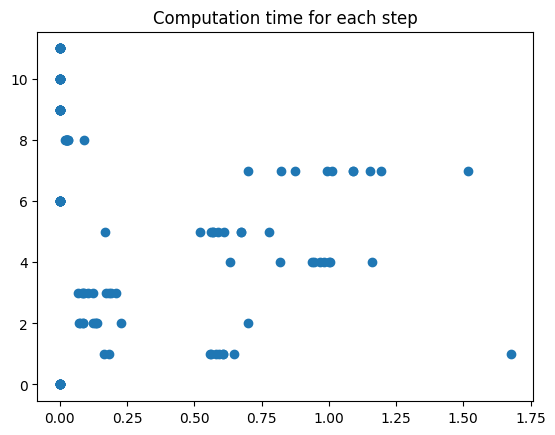

In [9]:
import matplotlib.pyplot as plt

plt.title('Computation time for each step')
plt.scatter(*np.array(sorted([time[1:] for times in all_times for time in times], key=lambda x: x[0], reverse=True)).T)

In [10]:
# from scipy.linalg import eigh

# %time real_evals, real_evecs = eigh(np.array(dense_rdd.map(lambda x: x[1]).collect()))

# Distributed Lanczos Algorithm

In [11]:
from pyspark.mllib.linalg.distributed import RowMatrix, DenseMatrix
from pyspark.mllib.linalg.distributed import BlockMatrix, IndexedRowMatrix
from scipy.linalg import eigh_tridiagonal
import numpy as np

def distributed_lanczos_algorithm(laplacian_matrix, m, block_size=1024):
    cols_per_block, rows_per_block = [block_size]*2

    def array_to_block_matrix(array, context):
        return IndexedRowMatrix(context.parallelize(array).zipWithIndex().map(lambda x: (x[1], [x[0]]))).toBlockMatrix(cols_per_block, rows_per_block)

    # grab the context object from the input matrix
    sc = laplacian_matrix.context

    # create a rdd of DenseVector rows
    dense_rdd = laplacian_matrix.map(lambda x: (x[0], x[1].toArray()))
    
    # convert dense_rdd to BlockMatrix object
    A_block = IndexedRowMatrix(dense_rdd).toBlockMatrix(cols_per_block, rows_per_block)
    
    # grab total columns from input matrix
    n = laplacian_matrix.map(lambda x: x[1].size).first()
    
    # initialize a random vector of size n and store in v_i as Block Matrix
    q = np.random.rand(n)
    q = q / np.linalg.norm(q)
    v_i = array_to_block_matrix(q, sc)
    
    # initialize empty lists for alpha and beta (diagonal and off diagonal of tridiagonal matrix T)
    alpha = []
    beta = []

    # Cache the A_block matrix as it is used multiple times
    A_block.cache()

    # Simple Lanczos method implementation
    for i in range(m):
        w_i = A_block.multiply(v_i)

        alpha_i = v_i.transpose().multiply(w_i)
        w_i = w_i.subtract(v_i.multiply(alpha_i))

        if i > 0:
            w_i = w_i.subtract(IndexedRowMatrix(v_im1.blocks.map(lambda x: (x[0][0], x[1].toArray() * beta_i))).toBlockMatrix(cols_per_block, rows_per_block).transpose())

        w_i_local = w_i.toLocalMatrix().toArray()
        beta_i = np.linalg.norm(w_i_local)

        if beta_i == 0:
            break

        v_ip1 = IndexedRowMatrix(w_i.blocks.map(lambda x: (x[0][0], x[1].toArray() / beta_i))).toBlockMatrix(cols_per_block, rows_per_block).transpose()
        alpha.append(alpha_i.toLocalMatrix().toArray()[0][0])
        beta.append(beta_i)
        v_im1 = v_i
        v_i = v_ip1

    # Get eigs from T (constructed from alpha and beta values)
    eig_vals, eig_vecs = eigh_tridiagonal(alpha, beta[:-1])

    return eig_vals, eig_vecs

In [12]:
%time eig_vals, eig_vecs = distributed_lanczos_algorithm(laplacian_matrix, 10, 1024)

CPU times: user 146 ms, sys: 60.9 ms, total: 206 ms
Wall time: 31.3 s


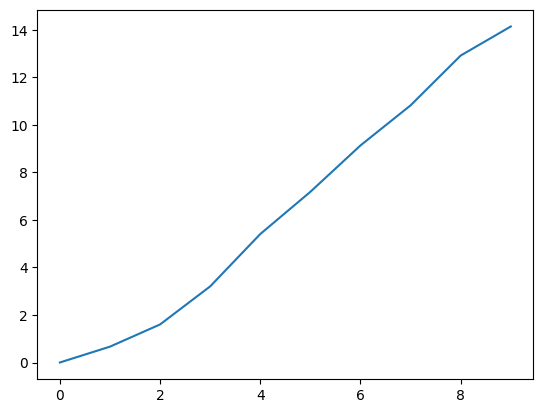

In [13]:
import matplotlib.pyplot as plt
plt.plot(eig_vals)